<a href="https://colab.research.google.com/github/saraswatiyangandul20/Analysis-of-Bank-Debit-Collection-and-Recovery-Strategies/blob/main/Which_Debts_Are_Worth_the_Bank's_Effort%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Which Debts Are Worth the Bank's Effort?

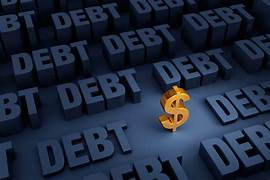

In [3]:
# Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd
# reading data file
dir_path = '/content/bank_data.csv'
df = pd.read_csv(dir_path)

In [7]:
df.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male


In [ ]:
df.tail()

In [9]:
df.shape

(1882, 6)

In [10]:
df.nunique()

id                          1882
expected_recovery_amount    1529
actual_recovery_amount      1882
recovery_strategy              5
age                           67
sex                            2
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1882 entries, 0 to 1881
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1882 non-null   int64  
 1   expected_recovery_amount  1882 non-null   int64  
 2   actual_recovery_amount    1882 non-null   float64
 3   recovery_strategy         1882 non-null   object 
 4   age                       1882 non-null   int64  
 5   sex                       1882 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 88.3+ KB


In [12]:
df.describe()

,id,expected_recovery_amount,actual_recovery_amount,age
count,1882.000000,1882.000000,1882.000000,1882.000000
mean,1035.596174,2759.967588,4000.967837,39.650372
std,591.458429,2019.826565,4576.506350,15.453072
min,6.000000,194.000000,200.425000,18.000000
25%,534.250000,1261.250000,1045.190300,28.000000
50%,1029.500000,2062.000000,2115.446373,35.000000
75%,1551.750000,3569.500000,5417.237207,50.000000
max,2056.000000,9964.000000,34398.479710,84.000000


In [13]:
df.isna().sum()

id                          0
expected_recovery_amount    0
actual_recovery_amount      0
recovery_strategy           0
age                         0
sex                         0
dtype: int64

##1.Graphical exploratory data analysis


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

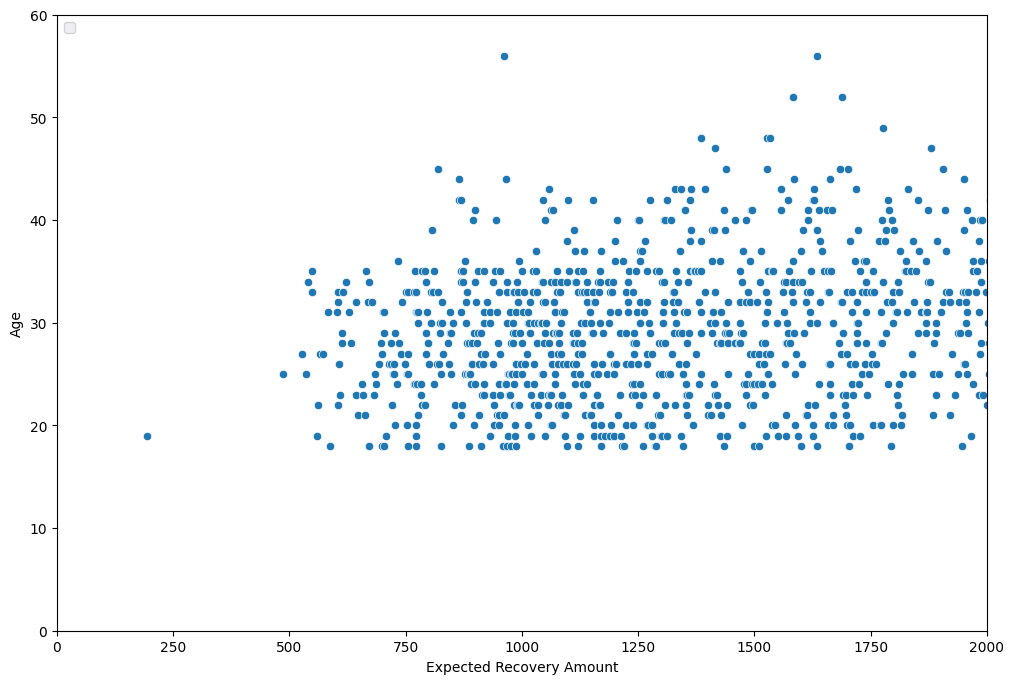

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
sns.set_style("darkgrid")
# Scatter plot of Age vs. Expected Recovery Amount
sns.scatterplot(x=df['expected_recovery_amount'], y=df['age'])
plt.xlim(0, 2000)
plt.ylim(0, 60)
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Age")
plt.legend(loc=2)

##2.Statistical test: age vs. expected recovery amount


In [16]:
# Compute average age just below and above the threshold
r_900_1100 = df.loc[(df['expected_recovery_amount']<1100) &
                      (df['expected_recovery_amount']>=900)]
by_recovery_strategy = r_900_1100.groupby(['recovery_strategy'])

In [18]:
Level_0_age = r_900_1100.loc[df['recovery_strategy'] == "Level 0 Recovery"]['age']
Level_1_age = r_900_1100.loc[df['recovery_strategy'] == "Level 1 Recovery"]['age']

# Perform a two-sample t-test
t_stat, p_value = stats.ttest_ind(Level_0_age, Level_1_age)

# Print the results
print(f"t-statistic: {t_stat}")
print(f"P-value: {p_value}")

t-statistic: -1.6888055955231507
P-value: 0.09297868115283911


In [19]:
by_recovery_strategy['age'].describe().unstack()

       recovery_strategy
count  Level 0 Recovery     89.000000
       Level 1 Recovery     94.000000
mean   Level 0 Recovery     27.224719
       Level 1 Recovery     28.755319
std    Level 0 Recovery      6.399135
       Level 1 Recovery      5.859807
min    Level 0 Recovery     18.000000
       Level 1 Recovery     18.000000
25%    Level 0 Recovery     23.000000
       Level 1 Recovery     24.000000
50%    Level 0 Recovery     26.000000
       Level 1 Recovery     29.000000
75%    Level 0 Recovery     31.000000
       Level 1 Recovery     33.000000
max    Level 0 Recovery     56.000000
       Level 1 Recovery     43.000000
dtype: float64

##3.Statistical test: sex vs. expected recovery amount


In [20]:
crosstab = pd.crosstab(df.loc[(df['expected_recovery_amount']<1100) &
                              (df['expected_recovery_amount']>=900)]['recovery_strategy'],
                       df['sex'])
# ... YOUR CODE FOR TASK 4 ...
print(crosstab)
# Chi-square test
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
# ... YOUR CODE FOR TASK 4 ...
print(p_val)

sex                Female  Male
recovery_strategy              
Level 0 Recovery       32    57
Level 1 Recovery       39    55
0.5377947810444592


In [21]:
# Chi-square test
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
print(p_val)

0.5377947810444592


##4.Exploratory graphical analysis: recovery amount


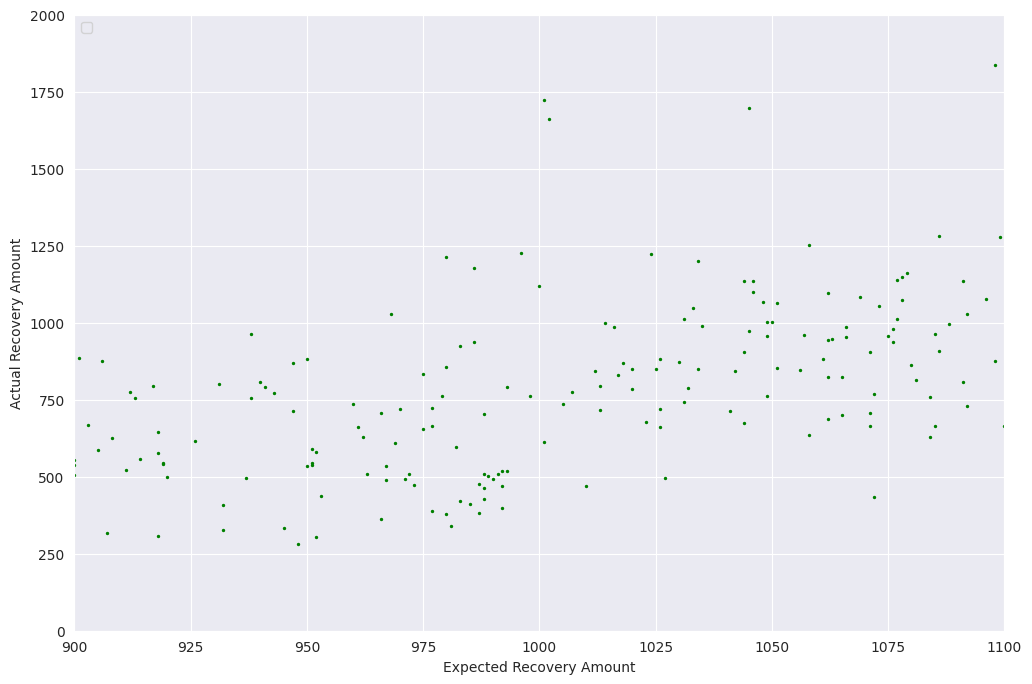

In [22]:
fig, ax = plt.subplots(figsize=(12,8))
# Scatter plot of Actual Recovery Amount vs. Expected Recovery Amount
plt.scatter(x=df['expected_recovery_amount'], y=df['actual_recovery_amount'], c="g", s=2)
plt.xlim(900, 1100)
plt.ylim(0, 2000)
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Actual Recovery Amount")
plt.legend(loc=2)

##5.Statistical analysis: recovery amount


In [23]:
# Compute average actual recovery amount just below and above the threshold
by_recovery_strategy['actual_recovery_amount'].describe().unstack()

# Perform Kruskal-Wallis test
Level_0_actual = r_900_1100.loc[df['recovery_strategy']=='Level 0 Recovery']['actual_recovery_amount']
Level_1_actual = r_900_1100.loc[df['recovery_strategy']=='Level 1 Recovery']['actual_recovery_amount']
print(stats.kruskal(Level_0_actual, Level_1_actual) )

# Repeat for a smaller range of $950 to $1050
r_950_1050 = df.loc[(df['expected_recovery_amount']<1050) &
                      (df['expected_recovery_amount']>=950)]
Level_0_actual = r_950_1050.loc[df['recovery_strategy']=='Level 0 Recovery']['actual_recovery_amount']
Level_1_actual = r_950_1050.loc[df['recovery_strategy']=='Level 1 Recovery']['actual_recovery_amount']
print(stats.kruskal(Level_0_actual, Level_1_actual))

KruskalResult(statistic=65.37966302528878, pvalue=6.177308752803109e-16)
KruskalResult(statistic=30.246000000000038, pvalue=3.80575314300276e-08)


##6.Regression modeling: no threshold

In [24]:
import statsmodels.api as sm

# Define X and y
X = r_900_1100['expected_recovery_amount']
y = r_900_1100['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Print out the model summary statistics
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.261
Model:                                OLS   Adj. R-squared:                  0.256
Method:                     Least Squares   F-statistic:                     63.78
Date:                    Thu, 05 Oct 2023   Prob (F-statistic):           1.56e-13
Time:                            15:49:51   Log-Likelihood:                -1278.9
No. Observations:                     183   AIC:                             2562.
Df Residuals:                         181   BIC:                             2568.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

##7.Regression modeling: adding true threshold


In [25]:
# Create indicator (0 or 1) for expected recovery amount >= $1000
import numpy as np
df['indicator_1000'] = np.where(df['expected_recovery_amount']<1000, 0, 1)
r_900_1100 = df.loc[(df['expected_recovery_amount']<1100) &
                      (df['expected_recovery_amount']>=900)]

# Define X and y
X = r_900_1100[['expected_recovery_amount','indicator_1000']]
y = r_900_1100['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y,X).fit()

# Print the model summary
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.314
Model:                                OLS   Adj. R-squared:                  0.307
Method:                     Least Squares   F-statistic:                     41.22
Date:                    Thu, 05 Oct 2023   Prob (F-statistic):           1.83e-15
Time:                            15:49:52   Log-Likelihood:                -1272.0
No. Observations:                     183   AIC:                             2550.
Df Residuals:                         180   BIC:                             2560.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

##8.Regression modeling: adjusting the window


In [26]:
# Redefine era_950_1050 so the indicator variable is included
r_950_1050 = df.loc[(df['expected_recovery_amount']<1050) &
                      (df['expected_recovery_amount']>=950)]

# Define X and y
X = r_950_1050[['expected_recovery_amount','indicator_1000']]
y = r_950_1050['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y,X).fit()

# Print the model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.283
Model:                                OLS   Adj. R-squared:                  0.269
Method:                     Least Squares   F-statistic:                     18.99
Date:                    Thu, 05 Oct 2023   Prob (F-statistic):           1.12e-07
Time:                            15:49:52   Log-Likelihood:                -692.92
No. Observations:                      99   AIC:                             1392.
Df Residuals:                          96   BIC:                             1400.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     -279.5243   1840.707     -0.152      0.880   -3933.298    3374.250
expected_recovery_amount     0.9189      1.886      0.487      0.627      -2.825       4.663
indicator_1000             286.5337    111.352      2.573      0.012      65.502     507.566
==============================================================================
Omnibus:                       39.302   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.258
Skew:                           1.564   Prob(JB):                     1.37e-18
Kurtosis:                       6.186   Cond. No.                     6.81e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""